In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from helper import readFile
from helper import oneHotEncoder
from helper import showConfusionMarix
from helper import getBatches
from NeuralNetwork import NeuralNetwork

%matplotlib inline

In [2]:
# read the data
trainFeature, trainLabel = readFile('./data/train/lab/hw2train_labels.txt', './data/')
devFeature, devLabel = readFile('./data/dev/lab/hw2dev_labels.txt', './data/')
evalFeature, evalLabel = readFile('./data/eval/lab/hw2eval_labels.txt', './data/')

# One-Hot-Encode for labels
trainLabel = oneHotEncoder(trainLabel, 9)
devLabel = oneHotEncoder(devLabel, 9)
evalLabel = oneHotEncoder(evalLabel, 9)

## TensorFlow

In [3]:
#########################################################
# Part 2: TensorFlow Analysis
print('*' * 60)
print('Part 2: TensorFlow Analysis')

************************************************************
Part 2: TensorFlow Analysis


In [4]:
# Help function for TensorFlow part
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def conv2d_valid(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

## TDNN model

In [5]:
# Hyper-parameters
batchSize = 50         # batch size
subIterate = 5         # select the first n batches from shuffled data
maxIterate = 1000      # maximum iteration
showFreq = 100         # frequency to control the logging information
learningRate = 0.01    # learning rate

In [6]:
# define list to save the training and test accuracy
trainAcc = []
devAcc = []
evalAcc = []

# begin the session
sess = tf.InteractiveSession()

# Create the model
x = tf.placeholder(tf.float32, shape=[None, 1120])
y_ = tf.placeholder(tf.float32, shape=[None, 9])

# reshape the input image
x_image = tf.reshape(x, [-1, 70, 16, 1])

# first convolutional layer
W_conv1 = weight_variable([3, 16, 1, 8])
b_conv1 = bias_variable([8])
# first processing
h_conv1 = tf.nn.relu(conv2d_valid(x_image, W_conv1) + b_conv1)
h_conv1 = tf.reshape(h_conv1, [-1, 68, 8, 1])

# second convolution layer
W_conv2 = weight_variable([5, 8, 1, 9])
b_conv2 = bias_variable([9])
# second processing
h_conv2 = tf.nn.relu(conv2d_valid(h_conv1, W_conv2) + b_conv2)

# Densely Connected Layer
W_fc = weight_variable([64 * 9, 9])
b_fc = bias_variable([9])

# readout layer
h_fc = tf.reshape(h_conv2, [-1, 64 * 9])
y_conv=tf.nn.softmax(tf.matmul(h_fc, W_fc) + b_fc)

# train and test the model
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

for i in range(1, maxIterate + 1):
    # shuffle and get batches
    X, y = shuffle(trainFeature, trainLabel)
    batchesX, batchesY = getBatches(X, y, batchSize)
    
    # training process
    j = 1
    for batchFeature, batchLabel in zip(batchesX, batchesY):
        if j == subIterate:
            break
        train_step.run(feed_dict={x: batchFeature, y_: batchLabel})
        j += 1
    
    # evaluate current model
    train_accuracy = accuracy.eval(feed_dict={x:trainFeature, y_: trainLabel})
    dev_accuracy = accuracy.eval(feed_dict={x:devFeature, y_: devLabel})
    eval_accuracy = accuracy.eval(feed_dict={x:evalFeature, y_: evalLabel})
    
    trainAcc.append(train_accuracy)
    devAcc.append(dev_accuracy)
    evalAcc.append(eval_accuracy)
        
    # keep recording the current process
    if i % showFreq == 0:
        print("Step %d, train, dev, eval accuracy \t%g, %g, %g,"%(i, np.round(train_accuracy, 5), 
                                                                  np.round(dev_accuracy, 5), 
                                                                  np.round(eval_accuracy, 5)))

print('Training is done !')
sess.close()

Step 200, train, dev, eval accuracy 	0.50909, 0.44323, 0.40814,
Step 400, train, dev, eval accuracy 	0.57312, 0.50068, 0.45765,
Step 600, train, dev, eval accuracy 	0.60909, 0.50068, 0.43674,
Step 800, train, dev, eval accuracy 	0.65119, 0.5212, 0.49505,
Step 1000, train, dev, eval accuracy 	0.67964, 0.52804, 0.50055,
Training is done !


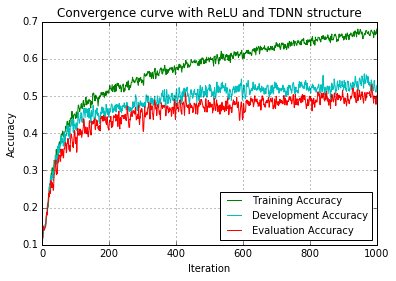

In [7]:
# plot the training accuracy
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(trainAcc, 'g', label='Training Accuracy')
ax.plot(devAcc, 'c', label='Development Accuracy')
ax.plot(evalAcc, 'r', label='Evaluation Accuracy')
ax.set_title('Convergence curve with ReLU and TDNN structure')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.legend(loc=4, fontsize=10)
ax.grid('on')
plt.show()

## CNN model

In [8]:
# Hyper-parameters
batchSize = 50
subIterate = 5
maxIterate = 500
showFreq = 50

In [9]:
# define list to save the training and test accuracy
trainAcc = []
devAcc = []
evalAcc = []

# begin the session
sess = tf.InteractiveSession()

# Create the model
x = tf.placeholder(tf.float32, shape=[None, 1120])
y_ = tf.placeholder(tf.float32, shape=[None, 9])

# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 8])
b_conv1 = bias_variable([8])

# reshape the input image
x_image = tf.reshape(x, [-1, 70, 16, 1])

# first processing
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# second convolution layer
W_conv2 = weight_variable([5, 5, 8, 3])
b_conv2 = bias_variable([3])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

# Densely Connected Layer
W_fc = weight_variable([70 * 16 * 3, 9])
b_fc = bias_variable([9])

h_conv2_flat = tf.reshape(h_conv2, [-1, 70 * 16 * 3])
y_conv=tf.nn.softmax(tf.matmul(h_conv2_flat, W_fc) + b_fc)

# train and test the model
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

for i in range(1, maxIterate + 1):
    # shuffle and get batches
    X, y = shuffle(trainFeature, trainLabel)
    batchesX, batchesY = getBatches(X, y, batchSize)
    
    # training process
    j = 1
    for batchFeature, batchLabel in zip(batchesX, batchesY):
        if j == subIterate:
            break
        train_step.run(feed_dict={x: batchFeature, y_: batchLabel})
        j += 1
    
    # evaluate current model
    train_accuracy = accuracy.eval(feed_dict={x:trainFeature, y_: trainLabel})
    dev_accuracy = accuracy.eval(feed_dict={x:devFeature, y_: devLabel})
    eval_accuracy = accuracy.eval(feed_dict={x:evalFeature, y_: evalLabel})
    
    trainAcc.append(train_accuracy)
    devAcc.append(dev_accuracy)
    evalAcc.append(eval_accuracy)
        
    # keep recording the current process
    if i % showFreq == 0:
        print("Step %d, train, dev, eval accuracy \t%g, %g, %g,"%(i, np.round(train_accuracy, 5), 
                                                                  np.round(dev_accuracy, 5), 
                                                                  np.round(eval_accuracy, 5)))

print('Training is done !')
sess.close()

Step 50, train, dev, eval accuracy 	0.40514, 0.342, 0.37294,
Step 100, train, dev, eval accuracy 	0.51739, 0.43365, 0.41474,
Step 150, train, dev, eval accuracy 	0.58972, 0.43502, 0.42904,
Step 200, train, dev, eval accuracy 	0.68182, 0.48153, 0.46095,
Step 250, train, dev, eval accuracy 	0.71621, 0.48974, 0.44224,
Step 300, train, dev, eval accuracy 	0.76482, 0.45417, 0.46205,
Step 350, train, dev, eval accuracy 	0.81126, 0.4829, 0.46425,
Step 400, train, dev, eval accuracy 	0.85257, 0.46922, 0.46535,
Step 450, train, dev, eval accuracy 	0.87213, 0.46238, 0.45105,
Step 500, train, dev, eval accuracy 	0.90672, 0.47332, 0.44994,
Training is done !


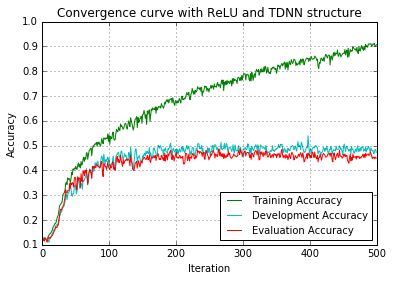

In [10]:
# plot the training accuracy
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(trainAcc, 'g', label='Training Accuracy')
ax.plot(devAcc, 'c', label='Development Accuracy')
ax.plot(evalAcc, 'r', label='Evaluation Accuracy')
ax.set_title('Convergence curve with ReLU and TDNN structure')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.legend(loc=4, fontsize=10)
ax.grid('on')
plt.show()